# First run on finetune
It's copied from main_pretrain_schlr.py, but with setting more similar to the base model finetuning for Image Classification in BEiT paper, which is followed by MAE paper. The constant lr after warmup and Clips gradient norm are removed. warmup epochs, weight decay, min. lr, optimizer settings are modified. Not yet implement the layer-wise lr decay.

The lr scheduler contains: warmup using LinearLR and decay using CosineAnnealingLR.
The batch size is 256, same as BERT.

The targets, $CaCO_3$ and $TOC$, are included together but not normalized. Hence, the loss function, MSE, is the sum of MSE of them both. It may be biased to the larger one, $CaCO_3$. $CaCO_3$ has larger values than $TOC$, so it may be better to normalize them first.

```
ViT model: base
Base learning rates: 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
Optimizer: AdamW (betas=((0.9, 0.999)), weight_decay=0.05) 
Data pre-processing: spectrum-wise standardization
Patch size: 16
Mask ratio: 0.75
Batch size: 256
Epochs: 100 (warmup: 20)
```
Details please refer to `models_regressor.py`, `engine_finetune` and `main_finetune.py`.


In [1]:
import pandas as pd

lr_df = pd.read_csv('results/tuning_lr_20240112.csv')
lr_df

,lr,min_val_loss
0,1.000000e-03,214.154823
1,1.000000e-04,214.155174
2,1.000000e-05,14.148001
3,1.000000e-06,13.911538
4,1.000000e-07,39.277384


Text(0, 0.5, 'Validation loss after 100 epochs')

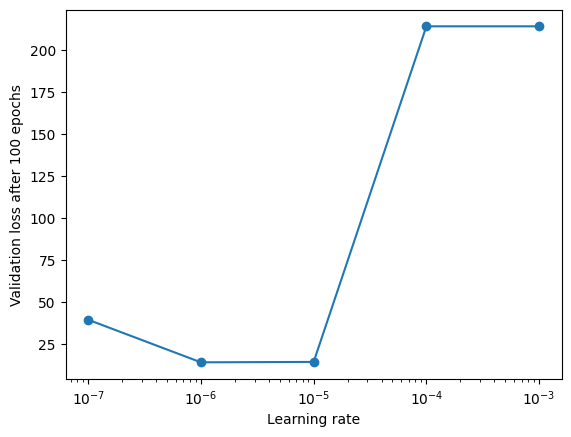

In [2]:
import matplotlib.pyplot as plt
plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Validation loss after 100 epochs')

________________________________________________________________________________
Learning rate: 0.001
Validation loss: 214.2


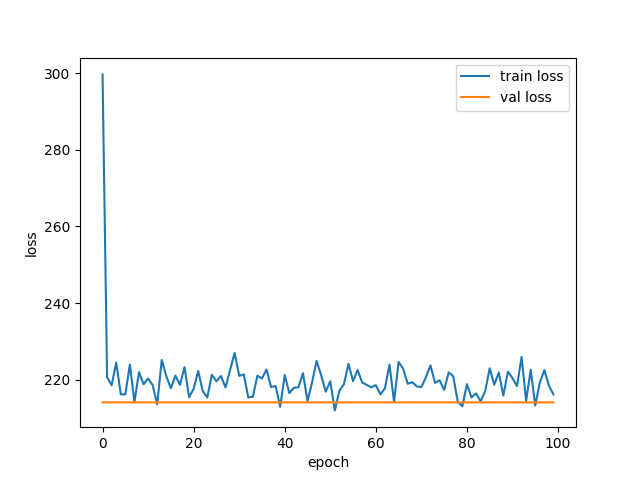

________________________________________________________________________________
Learning rate: 0.0001
Validation loss: 214.2


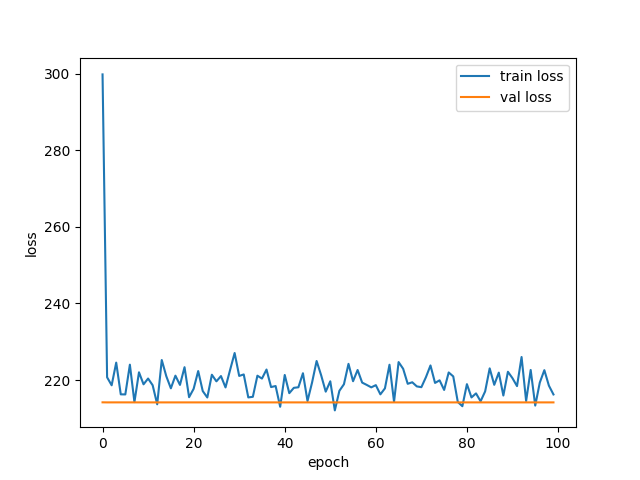

________________________________________________________________________________
Learning rate: 1e-05
Validation loss: 14.1


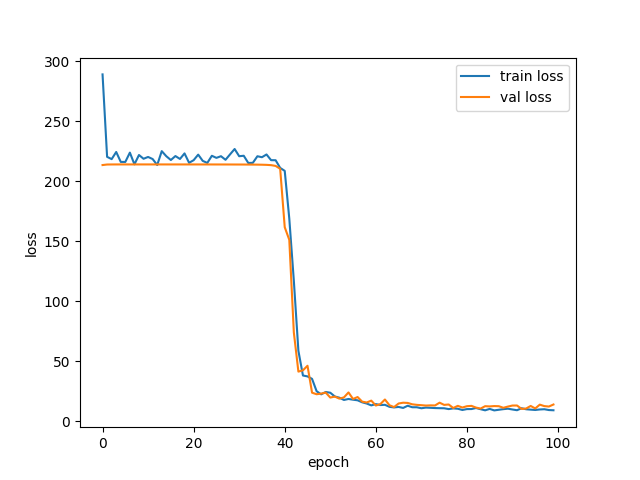

________________________________________________________________________________
Learning rate: 1e-06
Validation loss: 13.9


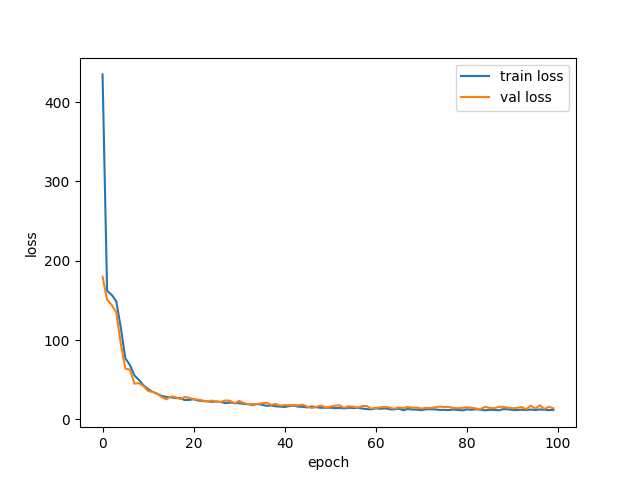

________________________________________________________________________________
Learning rate: 1e-07
Validation loss: 39.3


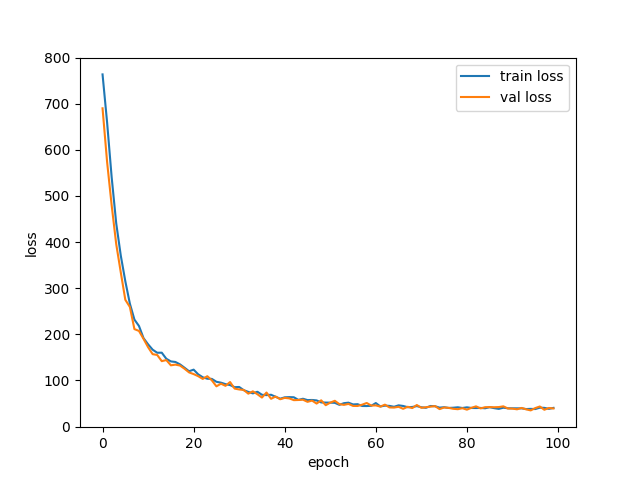

In [5]:
# display a png image
from IPython.display import Image, display
for _, (lr, loss) in lr_df.iterrows():
    img = Image(filename=f'results/loss_lr_{lr}_20240112.png')
    print('_'*80)
    print(f'Learning rate: {lr}')
    print(f'Validation loss: {loss:.1f}')
    display(img)

## Evaluate the optimal model
According to the loss above, the model with base lr 1e-6 converges faster and gives the lowest loss. Hence, we choose the model with base lr 1e-6 to see more detailed performance on the validation set.

In [1]:
import torch
from models_regressor import mae_vit_base_patch16
from util.datasets import get_dataloader, standardize

device = torch.device('cuda')
model = mae_vit_base_patch16(pretrained=True).to(device)
checkpoint = torch.load('models/mae_base_patch16_lr_1e-06_20240115.pth')
model.load_state_dict(checkpoint['model_state_dict'])

dataloader = get_dataloader(ispretrain=False, annotations_file='info_20240112.csv', input_dir='data/finetune/train', 
                            batch_size=256, transform=standardize)

In [48]:
from util.evaluate import finetune_evaluator 

eva = finetune_evaluator()
model_mse = eva.evaluate(model=model, dataloader=dataloader['val'])
base_mse = eva.evaluate_base(dataloader['val'])

r_square = 1 - model_mse / base_mse

print('CaCO3, TOC')
print(f'MSE: {model_mse}')
print(f'RMSR: {model_mse**0.5}')
print(f'MSE of base model: {base_mse}')
print(f'R2: {r_square}')

CaCO3, TOC
MSE: [30.833046    0.09189958]
RMSR: [5.552751   0.30314943]
MSE of base model: [3.35187678e+02 6.67947908e-02]
R2: [ 0.90801259 -0.37584952]


## Data analysis
Check the data characteristics (validation set).

In [3]:
from util.datasets import FinetuneDataset, standardize, split

dataset = FinetuneDataset(annotations_file='info_20240112.csv', input_dir='data/finetune/train', transform=standardize)
_, val_dataset = split(dataset)

In [41]:
target_list = []
for i in range(len(val_dataset)):
    target_list.append(val_dataset[i]['target'])

val_target_df = pd.DataFrame(target_list, columns=['CaCO3', 'TOC'])
val_target_df

,CaCO3,TOC
0,3.810000,1.163000
1,0.461174,0.076072
2,0.949126,0.229755
3,1.319795,0.093643
4,21.500000,0.261573
...,...,...
415,0.000000,0.777000
416,3.114398,0.116848
417,7.150322,0.143088
418,0.170693,0.194679


In [27]:
val_target_df.describe()

,CaCO3,TOC
count,420.000000,420.000000
mean,9.683793,0.265962
std,18.298001,0.261011
min,-0.623992,0.032302
25%,0.254441,0.114310
50%,1.127611,0.167716
75%,8.470239,0.289004
max,92.300000,1.258500


In [29]:
sum(val_target_df.CaCO3 < 0)

18

WTF, there are zeros and negative values in CaCO3...

In [42]:
val_target_df.CaCO3[val_target_df.CaCO3 <= 0] = 0.0001

In [43]:
import numpy as np
val_target_ln_df = val_target_df.apply(lambda x: np.log(x))

val_target_std_df = pd.DataFrame()
for col in val_target_df.columns:
    val_target_std_df[col] = (val_target_df[col] - val_target_df[col].mean()) / val_target_df[col].std()

val_target_df = pd.concat([val_target_df, val_target_ln_df, val_target_std_df], axis=1)
val_target_df

,CaCO3,TOC,CaCO3,TOC,CaCO3,TOC
0,3.810000,1.163000,1.337629,0.151003,-0.321325,3.436782
1,0.461174,0.076072,-0.773979,-2.576079,-0.504368,-0.727518
2,0.949126,0.229755,-0.052214,-1.470743,-0.477697,-0.138719
3,1.319795,0.093643,0.277476,-2.368266,-0.457437,-0.660198
4,21.500000,0.261573,3.068053,-1.341041,0.645588,-0.016814
...,...,...,...,...,...,...
415,0.000100,0.777000,-9.210340,-0.252315,-0.529570,1.957918
416,3.114398,0.116848,1.136036,-2.146883,-0.359346,-0.571294
417,7.150322,0.143088,1.967157,-1.944293,-0.138747,-0.470760
418,0.170693,0.194679,-1.767890,-1.636406,-0.520245,-0.273105


In [44]:
val_target_df.describe()

,CaCO3,TOC,CaCO3,TOC,CaCO3,TOC
count,420.000000,420.000000,420.000000,420.000000,4.200000e+02,4.200000e+02
mean,9.688750,0.265962,-0.081240,-1.673099,-7.190016e-17,-2.114711e-17
std,18.295331,0.261011,3.238585,0.798556,1.000000e+00,1.000000e+00
min,0.000100,0.032302,-9.210340,-3.432635,-5.295695e-01,-8.952117e-01
25%,0.254441,0.114310,-1.368737,-2.168860,-5.156676e-01,-5.810158e-01
50%,1.127611,0.167716,0.120074,-1.785485,-4.679412e-01,-3.764058e-01
75%,8.470239,0.289004,2.136329,-1.241316,-6.660227e-02,8.827909e-02
max,92.300000,1.258500,4.525044,0.229921,4.515428e+00,3.802667e+00


## Summary
The model with base lr 1e-6 gives the lowest loss on the validation set, 13.9. It's a combined MSE of $CaCO_3$ and $TOC$. I then evaluate these two targets separately. The results are 28.9 and 0.1 for $CaCO_3$ and $TOC$, respectively. The performance is worse than [Lee et al. (2022)](https://doi.org/10.1038/s41598-022-25377-x). After considering the data distribution by calculating $R^2$, the results are 0.91 and -0.5, respectively. This is expected. $CaCO_3$ has overall larger values and variance than $TOC$. When summing up their losses together without normalization during training, the model is biased to the larger one, $CaCO_3$. Hence, I should consider normalize them or simply train them separately.

To do:
1. Update dataset by replacing zeros and negative values.
2. Normalize the targets during training and validating. I choose standardization to make sure the targets are in the same scale. Not yet dealing with the skewness (log transformation).
1. Keep optimizing the model.